<a href="https://colab.research.google.com/github/Ajit-chaudhary-coder/Nepali_News_Scrapping/blob/main/Archive1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### With Contextual word embedding

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Clear TensorFlow backend session to avoid reusing old models
tf.keras.backend.clear_session()

# Load Dataset (assuming CSV with columns 'Content' and 'Category')
df = pd.read_csv('/content/drive/MyDrive/Dataset/news.csv')  # Replace with the actual path to your dataset
# df = df[:8000]
texts = df['Content'].tolist()  # List of text content
labels = df['Category'].tolist()  # List of category labels

# Encode Labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(np.unique(encoded_labels))

# Set Up MirroredStrategy for GPU parallelism
strategy = tf.distribute.MirroredStrategy()

# Define the tokenization function
def tokenize_texts(texts, tokenizer, max_len=512):
    tokens = tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=max_len)
    return tokens['input_ids'], tokens['attention_mask']

# BertLayer to Extract Contextual Word Embeddings
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertEmbeddingLayer, self).__init__(**kwargs)
        # Use the entire BERT model to get contextual embeddings
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        # Pass through the entire BERT model to get contextual embeddings
        outputs = self.bert_model(input_ids, attention_mask=attention_mask)
        # Extract the last hidden state (contextual embeddings)
        last_hidden_state = outputs.last_hidden_state
        return last_hidden_state

# Build Model
# Pass the Contextual Word Embeddings to the CNN-BiLSTM Model
def build_cnn_bilstm_model_with_bert_embeddings(bert_model, num_classes):
    input_ids = tf.keras.Input(shape=(512,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(512,), dtype=tf.int32, name='attention_mask')

    # Use BertEmbeddingLayer to get contextual embeddings
    bert_embeddings = BertEmbeddingLayer(bert_model)([input_ids, attention_mask])

    # CNN Layer
    cnn = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')(bert_embeddings)
    cnn = tf.keras.layers.MaxPooling1D(pool_size=2)(cnn)

    # BiLSTM Layer
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(cnn)
    pooled_output = tf.keras.layers.GlobalMaxPooling1D()(lstm)

    # Dense Layers
    dense = tf.keras.layers.Dense(64, activation='relu')(pooled_output)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(dense)

    # Build the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return model

# Model Building and Compilation Inside Strategy Scope
with strategy.scope():
    # Load BERT Tokenizer and Model inside the strategy scope
    tokenizer = BertTokenizer.from_pretrained('Rajan/NepaliBERT', from_pt=True)
    bert_model = TFBertModel.from_pretrained('Rajan/NepaliBERT', from_pt=True)

    # Tokenization and Padding
    input_ids, attention_masks = tokenize_texts(texts, tokenizer)

    # Convert TensorFlow tensors to NumPy arrays
    input_ids = input_ids.numpy()
    attention_masks = attention_masks.numpy()

    # Split Dataset into Train and Test Sets
    X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(
        input_ids, encoded_labels, attention_masks, test_size=0.2, random_state=42)

    # Further split the training set into training and validation sets
    X_train_final, X_val, y_train_final, y_val, mask_train_final, mask_val = train_test_split(
        X_train, y_train, mask_train, test_size=0.1, random_state=42)

    # Create TensorFlow datasets for training, validation, and test sets
    batch_size = 50
    # Train Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(
        ({"input_ids": X_train_final, "attention_mask": mask_train_final}, y_train_final))
    train_dataset = train_dataset.shuffle(len(X_train_final)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    # Validation dataset
    val_dataset = tf.data.Dataset.from_tensor_slices(
        ({"input_ids": X_val, "attention_mask": mask_val}, y_val))
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    # Test Dataset
    test_dataset = tf.data.Dataset.from_tensor_slices(
        ({"input_ids": X_test, "attention_mask": mask_test}, y_test))
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Build and compile the model within the strategy scope
    model = build_cnn_bilstm_model_with_bert_embeddings(bert_model, num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the Model
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)
# Predictions and true labels
y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)

# Evaluate the Model using the Dataset
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/987k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/328M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Epoch 1/20


995/995 [==============================] - 380s 357ms/step - loss: 0.9564 - accuracy: 0.7329 - val_loss: 0.6215 - val_accuracy: 0.8258
Epoch 2/20
995/995 [==============================] - 354s 355ms/step - loss: 0.5248 - accuracy: 0.8484 - val_loss: 0.4518 - val_accuracy: 0.8677
Epoch 3/20
995/995 [==============================] - 353s 355ms/step - loss: 0.4198 - accuracy: 0.8733 - val_loss: 0.4094 - val_accuracy: 0.8737
Epoch 4/20
995/995 [==============================] - 353s 355ms/step - loss: 0.3510 - accuracy: 0.8926 - val_loss: 0.3788 - val_accuracy: 0.8829
Epoch 5/20
995/995 [==============================] - 353s 355ms/step - loss: 0.3055 - accuracy: 0.9063 - val_loss: 0.3431 - val_accuracy: 0.8967
Epoch 6/20
995/995 [==============================] - 353s 355ms/step - loss: 0.2641 - accuracy: 0.9193 - val_loss: 0.3456 - val_accuracy: 0.8945
Epoch 7/20
995/995 [==============================] - 354s 355ms/step - loss: 0.2316 - accuracy: 0.9299 - val_loss: 0.3256 - val_accura

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize # import the label_binarize function


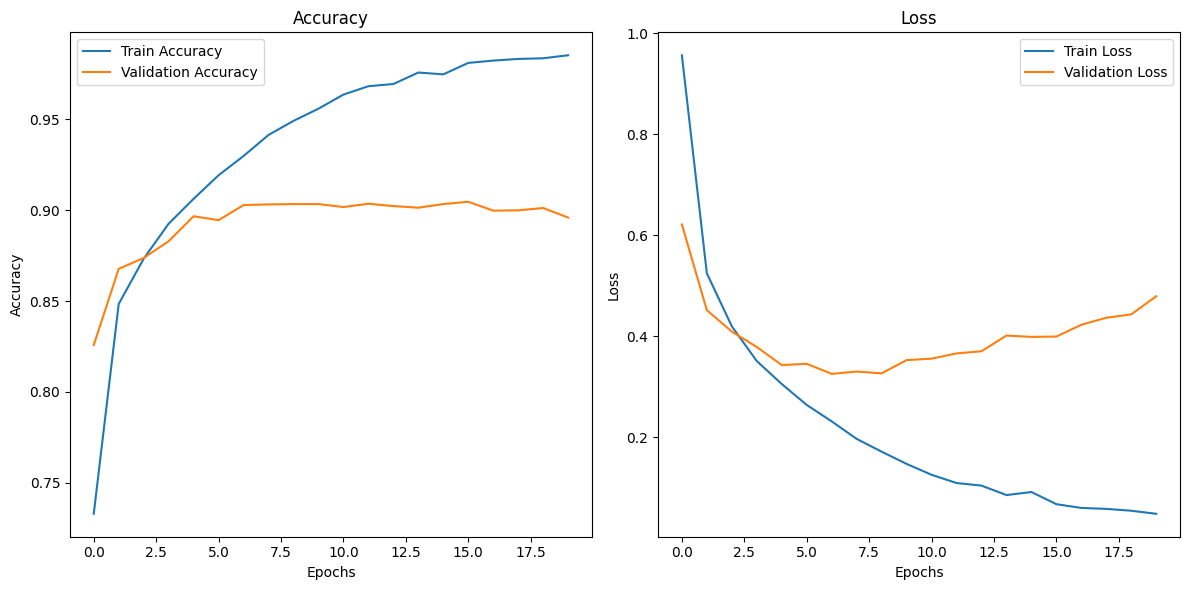

In [ ]:
# Plot accuracy and loss curves
def plot_training_history(history):
    # Plot Accuracy
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


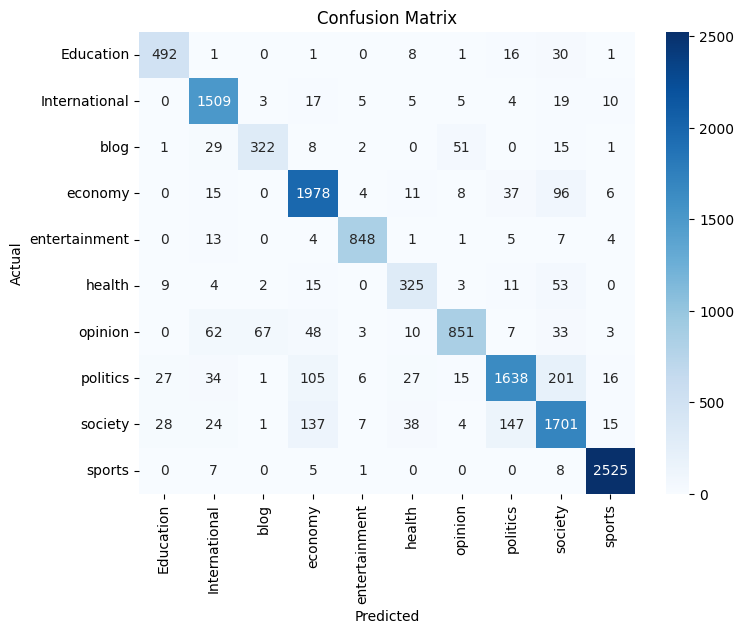

               precision    recall  f1-score   support

    Education       0.88      0.89      0.89       550
International       0.89      0.96      0.92      1577
         blog       0.81      0.75      0.78       429
      economy       0.85      0.92      0.88      2155
entertainment       0.97      0.96      0.96       883
       health       0.76      0.77      0.77       422
      opinion       0.91      0.79      0.84      1084
     politics       0.88      0.79      0.83      2070
      society       0.79      0.81      0.80      2102
       sports       0.98      0.99      0.98      2546

     accuracy                           0.88     13818
    macro avg       0.87      0.86      0.87     13818
 weighted avg       0.88      0.88      0.88     13818



In [ ]:
# Predictions and true labels
# y_pred = model.predict(test_dataset)
# y_pred_labels = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
            xticklabels=label_encoder.classes_.astype(str),
            yticklabels=label_encoder.classes_.astype(str))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_.astype(str)))

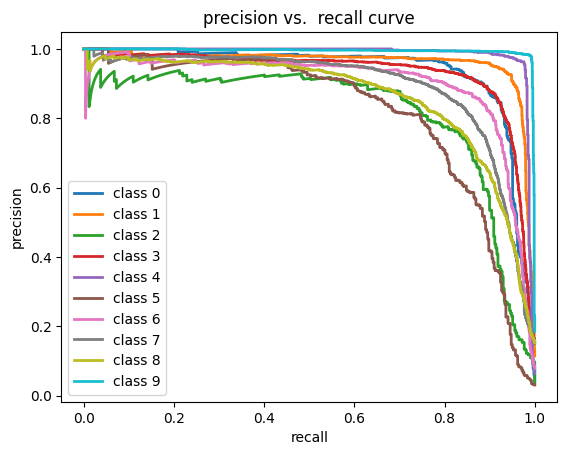

In [ ]:
# Precision-Recall Curve for Multiclass Classification

# Iterate over each class
precision = dict()
recall = dict()
for i in range(num_classes): # num_classes is the number of classes in your dataset
    precision[i], recall[i], _ = precision_recall_curve(y_test == i, y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs.  recall curve")
plt.show()

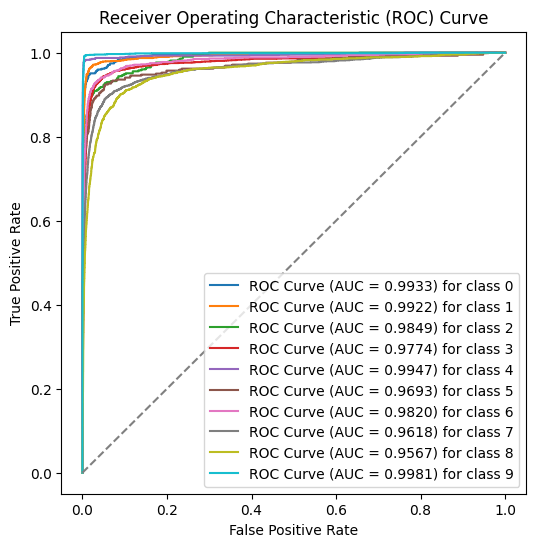

In [ ]:
# ROC Curve for multiclass classification

# !pip install scikit-learn # install scikit-learn if it's not already installed.


# Binarize the output
y_test_binary = label_binarize(y_test, classes=np.unique(y_test))

# Iterate over each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=plt.cm.tab10(i),
             label=f'ROC Curve (AUC = {roc_auc[i]:.4f}) for class {i}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
# model symmary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert_embedding_layer (Bert  (None, 512, 768)             8191411   ['input_ids[0][0]',           
 EmbeddingLayer)                                          2          'attention_mask[0][0]']      
                                                                                              

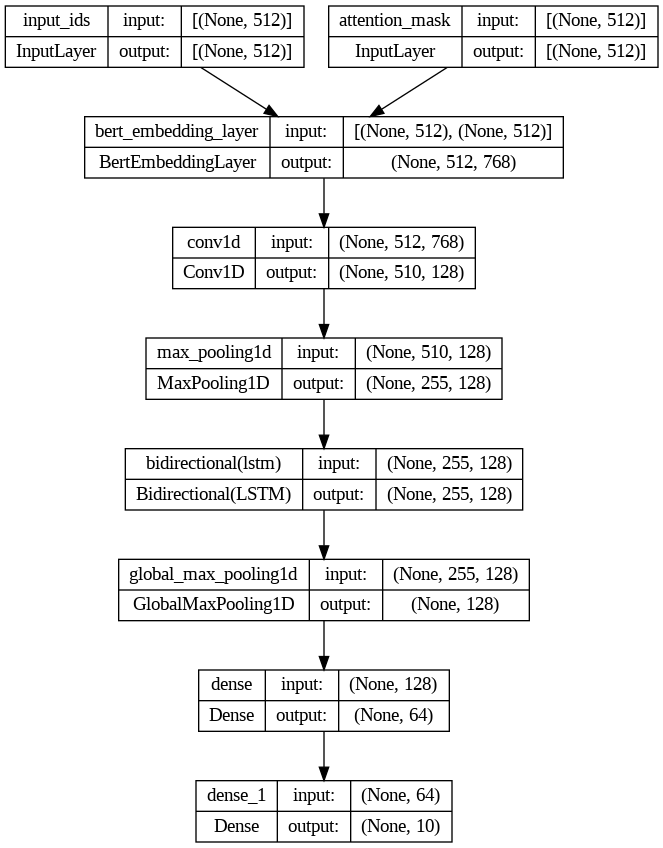

In [ ]:
# Plot the model architecture and save to the specified file
tf.keras.utils.plot_model(model, to_file='BER-CNN-BiLSTM_model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


NameError: name 'model' is not defined